In [106]:
import cv2
import math
from scipy import ndimage
import numpy as np

from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
from collections import defaultdict

from math import sin, cos, atan
# from processors import Opener, Closer, EdgeDetector
import pickle


In [109]:
class Resizer:
    """Resizes image.
    Params
    ------
    image   is the image to be resized
    height  is the height the resized image should have. Width is changed by similar ratio.
    """
    def __init__(self, height = 4128, output_process = False):
        self._height = height
        self.output_process = output_process


    def __call__(self, image):
        if image.shape[0] <= self._height: return image
        ratio = round(self._height / image.shape[0], 3)
        width = int(image.shape[1] * ratio)
        dim = (width, self._height)
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
        if self.output_process: cv2.imwrite('/content/resized.jpg', resized)
        return resized

In [110]:
class OtsuThresholder:
    # Thresholds image by using the otsu method

    def __init__(self, thresh1 = 0, thresh2 = 255, output_process = False):
        self.output_process = output_process
        self.thresh1 = thresh1
        self.thresh2 = thresh2


    def __call__(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        T_, thresholded = cv2.threshold(image, self.thresh1, self.thresh2, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if self.output_process: 
            cv2.imwrite('/content/thresholded.jpg', thresholded)
        return thresholded

In [111]:
class FastDenoiser:
    """Denoises image by using the fastNlMeansDenoising method
    Params
    ------
    image       is the image to be Thresholded
    strength    the amount of denoising to apply
    """
    def __init__(self, strength = 7, output_process = False):
        self._strength = strength
        self.output_process = output_process


    def __call__(self, image):
        temp = cv2.fastNlMeansDenoising(image, h = self._strength)
        if self.output_process: cv2.imwrite('/content/denoised.jpg', temp)
        return temp

In [112]:
class Closer:
    # Used to generate an thresholded image of the paper without the text on it
    def __init__(self, kernel_size = 3, iterations = 10, output_process = False):
        self._kernel_size = kernel_size
        self._iterations = iterations
        self.output_process = output_process


    def __call__(self, image):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self._kernel_size, self._kernel_size))

        # Closing operation to remove small holes inside the foreground objects, or small black points on the object.
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel,iterations = self._iterations)

        if self.output_process: 
            cv2.imwrite('/content/closed.jpg', closed)
        return closed

In [114]:
class EdgeDetector:
    def __init__(self, output_process = False):
        self.output_process = output_process

    def __call__(self, image, thresh1 = 50, thresh2 = 150, apertureSize = 3):
        edges = cv2.Canny(image, thresh1, thresh2, apertureSize = apertureSize)
        if self.output_process: cv2.imwrite('/content/edges.jpg', edges)
        return edges

In [115]:
class HoughLineCornerDetector:
    def __init__(self, rho_acc = 2, theta_acc = 360, thresh = 100, output_process = True):
        self.rho_acc = rho_acc
        self.theta_acc = theta_acc
        self.thresh = thresh
        self.output_process = output_process
        self._preprocessor = [
            Closer(output_process = output_process), 
            EdgeDetector(output_process = output_process)
        ]

    def __call__(self, image):
        # Step 1: Process for edge detection
        self._image = image
        for processor in self._preprocessor:
            self._image = processor(self._image)
        
        # Step 2: Get hough lines
        self._lines = self._get_hough_lines()

        # Step 3: Get intersection points
        self._intersections = self._get_intersections()

        # Step 4: Get Quadrilaterals
        return self._find_quadrilaterals()

    
    def _get_hough_lines(self):
        lines = cv2.HoughLines(self._image, self.rho_acc, np.pi / self.theta_acc, self.thresh)
        if self.output_process: self._draw_hough_lines(lines)
        return lines

    
    def _draw_hough_lines(self, lines):
        hough_line_output = self._get_color_image()

        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            n = 5000
            x1 = int(x0 + n * (-b))
            y1 = int(y0 + n * (a))
            x2 = int(x0 - n * (-b))
            y2 = int(y0 - n * (a))

            cv2.line(hough_line_output, (x1, y1), (x2, y2), (0, 0, 255), 2)

        cv2.imwrite('/content/hough_line.jpg', hough_line_output)

    def _get_intersections(self):
        """Finds the intersections between groups of lines."""
        lines = self._lines
        intersections = []
        group_lines = combinations(range(len(lines)), 2)
        x_in_range = lambda x: 0 <= x <= self._image.shape[1]
        y_in_range = lambda y: 0 <= y <= self._image.shape[0]

        for i, j in group_lines:
            line_i, line_j = lines[i][0], lines[j][0]
            
            if 80.0 < self._get_angle_between_lines(line_i, line_j) < 100.0:
                int_point = self._intersection(line_i, line_j)
                
                if x_in_range(int_point[0][0]) and y_in_range(int_point[0][1]): 
                    intersections.append(int_point)

        if self.output_process: 
            self._draw_intersections(intersections)
        return intersections


    def _find_quadrilaterals(self):
        X = np.array([[point[0][0], point[0][1]] for point in self._intersections])
        kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0).fit(X)
        if self.output_process: 
            self._draw_quadrilaterals(self._lines, kmeans)
        return  [[center.tolist()] for center in kmeans.cluster_centers_]


    def _draw_quadrilaterals(self, lines, kmeans):
        grouped_output = self._get_color_image()

        for idx, line in enumerate(lines):
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            n = 5000
            x1 = int(x0 + n * (-b))
            y1 = int(y0 + n * (a))
            x2 = int(x0 - n * (-b))
            y2 = int(y0 - n * (a))

            cv2.line(grouped_output, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        with open('/content/cluster_centers.pickle', 'wb') as handle:
            pickle.dump(kmeans.cluster_centers_, handle, protocol=pickle.HIGHEST_PROTOCOL)

        for point in kmeans.cluster_centers_:
            x, y = point
            cv2.circle(grouped_output,(int(x), int(y)),5,(255, 255, 255),5)

        cv2.imwrite('/content/grouped.jpg', grouped_output)

    
    def _get_angle_between_lines(self, line_1, line_2):
        rho1, theta1 = line_1
        rho2, theta2 = line_2
        m1 = -(np.cos(theta1) / np.sin(theta1))
        m2 = -(np.cos(theta2) / np.sin(theta2))
        return abs(atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi)

    
    def _intersection(self, line1, line2):
        rho1, theta1 = line1
        rho2, theta2 = line2

        A = np.array([[np.cos(theta1), np.sin(theta1)],[np.cos(theta2), np.sin(theta2)]])
        b = np.array([[rho1], [rho2]])
        x0, y0 = np.linalg.solve(A, b)
        x0, y0 = int(np.round(x0)), int(np.round(y0))
        return [[x0, y0]]


    def _draw_intersections(self, intersections):
        intersection_point_output = self._get_color_image()

        for line in self._lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            n = 5000
            x1 = int(x0 + n * (-b))
            y1 = int(y0 + n * (a))
            x2 = int(x0 - n * (-b))
            y2 = int(y0 - n * (a))

            cv2.line(intersection_point_output, (x1, y1), (x2, y2), (0, 0, 255), 2)

        for point in intersections:
            x, y = point[0]
            cv2.circle(intersection_point_output,(x, y),5,(255, 255, 127),5)

        cv2.imwrite('/content/intersection_point_output.jpg', intersection_point_output)

    def _get_color_image(self):
        return cv2.cvtColor(self._image.copy(), cv2.COLOR_GRAY2RGB)

In [116]:
class PageExtractor:
    def __init__(self, preprocessors, corner_detector, output_process = False):
        assert isinstance(preprocessors, list), "List of processors expected"
        self._preprocessors = preprocessors
        self._corner_detector = corner_detector
        self.output_process = output_process


    def __call__(self, image_path):
        # Step 1: Read image from file
        self._image = cv2.imread(image_path)

        # Step 2: Preprocess image
        self._processed = self._image
        for preprocessor in self._preprocessors:
            self._processed = preprocessor(self._processed)

        self._intersections = self._corner_detector(self._processed)

        # Step 3: Deskew and extract page
        return self._extract_page()


    def _extract_page(self):
        # obtain a consistent order of the points and unpack them
        # individually
        pts = np.array([
            (x, y)
            for intersection in self._intersections
            for x, y in intersection
        ])
        rect = self._order_points(pts)
        (tl, tr, br, bl) = rect

        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],                         # Top left point
            [maxWidth - 1, 0],              # Top right point
            [maxWidth - 1, maxHeight - 1],  # Bottom right point
            [0, maxHeight - 1]],            # Bottom left point
            dtype = "float32"               # Date type
        )

        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(self._processed, M, (maxWidth, maxHeight))

        if self.output_process: cv2.imwrite('/content/deskewed.jpg', warped)

        # return the warped image
        return warped

    
    def _order_points(self, pts):
        """
        Function for getting the bounding box points in the correct
        order

        Params
        pts     The points in the bounding box. Usually (x, y) coordinates

        Returns
        rect    The ordered set of points
        """
        # initialzie a list of coordinates that will be ordered such that 
        # 1st point -> Top left
        # 2nd point -> Top right
        # 3rd point -> Bottom right
        # 4th point -> Bottom left
        rect = np.zeros((4, 2), dtype = "float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        # return the ordered coordinates
        return rect

In [121]:
# from hough_line_corner_detector import HoughLineCornerDetector
# from processors import Resizer, OtsuThresholder, FastDenoiser
# 1280

page_extractor = PageExtractor(
        preprocessors = [
            Resizer(height = 4128, output_process = True), 
            FastDenoiser(strength = 9, output_process = True)
            # OtsuThresholder(output_process = True)
        ],
        corner_detector = HoughLineCornerDetector(rho_acc = 1,theta_acc = 180,thresh = 100,output_process = True)
    )

In [122]:
input_image = '/content/img_wood_2.jpg'
extracted = page_extractor(input_image)
cv2.imwrite('/content/extracted.jpg', extracted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in float_scalars


True

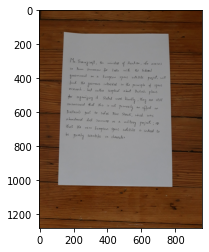

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/resized.jpg')

# img = cv2.imread('/content/img_wood_2.jpg')


img_copy = np.copy(img)
img_copy = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)
plt.imshow(img_copy)


In [120]:
import pickle

with open('/content/cluster_centers.pickle', 'rb') as handle:
    corners = pickle.load(handle)

In [103]:
corners_f = np.float32(corners)
corners_f

array([[ 765.      ,  139.      ],
       [ 108.333336, 1027.      ],
       [ 144.66667 ,  139.11111 ],
       [ 788.5     , 1039.      ]], dtype=float32)

In [104]:
img.shape

(1280, 959, 3)

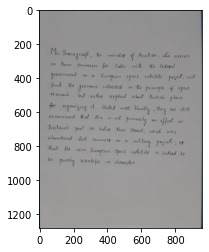

In [105]:
# Pick 4 points to generate the transformation matrix
input_pts = np.float32([corners_f[2], corners_f[0], corners_f[1], corners_f[3]])
# input_pts = corners_f
output_pts = np.float32([[0,0],[img.shape[1],0],[0,img.shape[0]],[img.shape[1],img.shape[0]]])

# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)

# Apply the perspective transformation to the image
out = cv2.warpPerspective(img,M,(img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)

plt.imshow(out)
# cv2.imwrite('/content/fin_out.jpg', out)

In [124]:
image = cv2.imread('/content/extracted (3).jpg')
resized_image = cv2.resize(image, (2204, 2896))
cv2.imwrite('/content/out_out.jpg', resized_image)

True